# Import thư viện cần thiết

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Đọc dữ liệu

In [2]:
train = pd.read_csv('../data/train_preprocessed.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target,rez_esc-missing
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,...,1849,1,100,0,1.000000,0.0,100.0,1849,4,False
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,4489,1,144,0,1.000000,64.0,144.0,4489,4,False
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,...,8464,1,0,0,0.250000,64.0,121.0,8464,4,False
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,289,16,121,4,1.777778,1.0,121.0,289,4,False
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,1369,16,121,4,1.777778,1.0,121.0,1369,4,False


In [3]:
test = pd.read_csv('../data/test_preprocessed.csv')
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,rez_esc-missing
0,ID_2f6873615,0.0,0,5,0,1,1,0,0.0,1,...,0,16,9,0,1,2.25,0.25,272.25,16,False
1,ID_1c78846d2,0.0,0,5,0,1,1,0,0.0,1,...,256,1681,9,0,1,2.25,0.25,272.25,1681,False
2,ID_e5442cf6a,0.0,0,5,0,1,1,0,0.0,1,...,289,1681,9,0,1,2.25,0.25,272.25,1681,False
3,ID_a8db26a79,0.0,0,14,0,1,1,1,1.0,0,...,256,3481,1,256,0,1.00,0.00,256.00,3481,False
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,121,324,1,0,1,0.25,64.00,NaN,324,True


In [4]:
ntrain = train.shape[0]
ntest = test.shape[0]

all_data = pd.concat((train, test)).reset_index(drop=True)

# Xây dựng mô hình học máy

## Loại bỏ những thuộc tính dư thừa

### Tạo biến ordinal từ dữ liệu đã được one-hot encode

Các thuộc tính như `epared`, `etecho`, `eviv` và `instlevel` có thể được chuyển về dạng dữ liệu ordinal với quy ước **(bad, regular, good) -> (0, 1, 2)**

In [5]:
def get_numeric(data, status_name):
    status_cols = [s for s in data.columns.tolist() if status_name in s]
    status_df = data[status_cols]
    status_df.columns = list(range(status_df.shape[1]))
    status_numeric = status_df.idxmax(1)
    status_numeric.name = status_name
    data = pd.concat([data, status_numeric], axis=1)
    return data

In [6]:
status_name_list = ['epared', 'etecho', 'eviv', 'instlevel']
for status_name in status_name_list:
    all_data = get_numeric(all_data, status_name)

### Xóa những thuộc tính không cần thiết

Nhóm nhận thấy có những thuộc tính có thể được xác định bằng những thuộc tính khác trong dữ liệu.

* Nhóm thuộc tính sau có thể được tạo ra bằng sự kết hợp từ `r4h` và `r4m`:
    ```
    r4t1, persons younger than 12 years of age
    r4t2, persons 12 years of age and older
    r4t3, Total persons in the household
    ```

* Các thuộc tính sau mang cùng ý nghĩa với `hogar_total`:
    ```
    tamhog, size of the household
    tamviv, number of persons living in the household
    hhsize, household size
    r4t3, Total persons in the household
    ```

* `v18q` có thể được tạo ra từ `v18q1`.
* `mobilephone` có thể được tạo ra từ `qmobilephone`.
* `epared1~3`, `etecho1~3`, `eviv1~3`, `instlevel1~9` do đã được chuyển đổi thành dữ liệu ordinal nên sẽ không dùng đến nữa.

In [7]:
redundant_features = ['r4t1', 'r4t2', 'r4t3', 
                      'tamhog', 'tamviv', 'hhsize', 'r4t3', 
                      'v18q', 'mobilephone',
                      'epared1', 'epared2', 'epared3', 
                      'etecho1', 'etecho2', 'etecho3',
                      'eviv1', 'eviv2', 'eviv3', 
                      'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']
all_data.drop(columns=redundant_features, inplace=True)

## Trích lọc đặc trưng bằng thông số thống kê

Để kết hợp dữ liệu của từng cá nhân vào dữ liệu của cả hộ gia đình, ta cần tổng hợp dữ liệu đó cho từng hộ gia đình. Cách đơn giản nhất để thực hiện việc này là nhóm dữ liệu theo `idhogar` rồi tổng hợp dữ liệu. Tuy nhiên, các dữ liệu **boolean** có thể giống nhau, và sẽ tạo ra nhiều cột dư thừa mà sau đó chúng ta sẽ cần phải loại bỏ sau khi triển khai.

In [8]:
ind_bool = ['dis', 'male', 'female', 
            'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 
            'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12', 'instlevel']

ind_ordered = ['escolari', 'age']

In [9]:
range = lambda x: x.max() - x.min()
range.__name__ = 'range_'
ind_agg = all_data.groupby('idhogar')[ind_ordered + ind_bool].agg(['mean', 'max', 'min', 'sum', 'count', 'std', range])

new_cols = []
for col in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')

ind_agg.columns = new_cols
ind_agg.head()

,escolari-mean,escolari-max,escolari-min,escolari-sum,escolari-count,escolari-std,escolari-range_,age-mean,age-max,age-min,...,parentesco12-count,parentesco12-std,parentesco12-range_,instlevel-mean,instlevel-max,instlevel-min,instlevel-sum,instlevel-count,instlevel-std,instlevel-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,8.666667,14,0,26,3,7.571878,14,20.666667,30,4,...,3,0.0,0,4.666667,7,0,14,3,4.041452,7
000bce7c4,2.500000,5,0,5,2,3.535534,5,61.500000,63,60,...,2,0.0,0,0.500000,1,0,1,2,0.707107,1
001845fb0,10.250000,14,6,41,4,3.304038,8,35.500000,52,19,...,4,0.0,0,4.000000,7,2,16,4,2.160247,5
001ff74ca,8.000000,16,0,16,2,11.313708,16,19.000000,38,0,...,2,0.0,0,3.500000,7,0,7,2,4.949747,7
003514e22,7.250000,14,0,29,4,5.852350,14,24.000000,39,6,...,4,0.0,0,3.000000,7,0,12,4,2.943920,7


In [10]:
corr_matrix = ind_agg.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
print(f'There are {len(to_drop)} correlated columns to remove.')

There are 82 correlated columns to remove.


In [11]:
all_data = all_data.merge(ind_agg, on = 'idhogar', how = 'left')
all_data.drop(columns=ind_bool+ind_ordered+to_drop, inplace=True)
print('Number of features after dropping the individual level features', all_data.shape[1])

Number of features after dropping the individual level features 190


## Xây dựng model

Chia dữ liệu

In [12]:
train = all_data[:ntrain][:]
test = all_data[ntrain:][:]

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error,make_scorer

In [14]:
train.set_index(['Id', 'idhogar'], inplace=True)
test.set_index(['Id', 'idhogar'], inplace=True)
X = train.drop('Target', axis = 1)
Y = train['Target']

In [15]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
X = imputer.fit_transform(X)
# new_test_df = imputer.fit_transform(test.iloc[:, :-1])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X ,Y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6886, 187), (1722, 187), (6886,), (1722,))

In [17]:
knnModel = Pipeline([('model',KNeighborsRegressor())])
knnModel.fit(X_train,y_train)
predictions=knnModel.predict(X_test)

Text(0, 0.5, 'Predict')

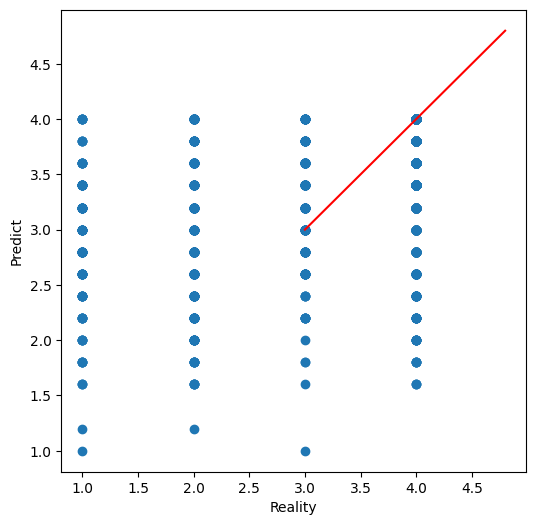

In [18]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(3,5,0.2),np.arange(3,5,0.2),color='red')
plt.scatter(y_test, predictions)
plt.xlabel("Reality")
plt.ylabel("Predict")

In [19]:
def accuracy(y, y_hat):
    return (y == y_hat).sum() / y.shape[0]

In [20]:
print(accuracy(y_test, predictions))

0.24099883855981416


In [22]:
knnModel = Pipeline([('scaler',StandardScaler()),('model',KNeighborsRegressor())])
knnModel.fit(X_train,y_train)
predictions=knnModel.predict(X_test)

In [23]:
print(accuracy(y_test, predictions))

0.5255516840882695


In [25]:
def mse_score(y_true,y_predict):
    return -mean_squared_error(y_true,y_predict)

In [26]:
knnModel = Pipeline([('scaler',StandardScaler()),('model',KNeighborsRegressor())])
mod=GridSearchCV(estimator=knnModel,
                param_grid={'model__n_neighbors':np.arange(1,100)},
                scoring={'mse':make_scorer(accuracy)},
                refit='mse',
                cv=5)
mod.fit(X,Y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             refit='mse',
             scoring={'mse': make_scorer(accuracy, response_method='predict')})

In [27]:
mod.best_params_

{'model__n_neighbors': 1}

In [28]:
modified_knnModel = Pipeline([('scaler',StandardScaler()),('model',
                                KNeighborsRegressor(n_neighbors=mod.best_params_['model__n_neighbors']))])
modified_knnModel.fit(X_train,y_train)
knn_predictions=modified_knnModel.predict(X_test)

In [29]:
print(accuracy(y_test, knn_predictions))

0.9547038327526133
